In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
import calendar
import time
from matplotlib import colors
from sklearn import preprocessing
import cartopy.crs as crs
import cartopy.feature as cfeature
import scipy

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def read_data(init):
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # need to remove the random forecasts that have forecast hours 0
    # these are random because they only exist in the files that Ryan T. provided
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [3]:
def format_df(df):
    df = df[df["lead_time_DAY"] == 0]
    df = df[df["lead_time_HOUR"] <= 18]
    error_months = (
        (df.groupby([df.time.dt.month, "station"])[f"t2m_error"].mean())
        .to_frame()
        .reset_index()
    )
    return error_months

In [4]:
def get_corrs(df, lulc, keys):
    df_pers = pd.DataFrame()
    df_rho = pd.DataFrame()
    df_tau = pd.DataFrame()
    df_p_score = pd.DataFrame()
    for i in np.arange(1, 13):
        pers_ls = []
        rho_ls = []
        tau_ls = []
        p_score_ls = []
        df = months_df[months_df["time"] == i]
        for col, val in lulc.iteritems():
            # get correlations
            pers = scipy.stats.pearsonr(lulc[col], df["t2m_error"])[0]
            p_score = scipy.stats.pearsonr(lulc[col], df["t2m_error"])[1]
            rho = scipy.stats.spearmanr(lulc[col], df["t2m_error"])[0]
            tau = scipy.stats.kendalltau(lulc[col], df["t2m_error"])[0]

            # append
            pers_ls.append(pers)
            rho_ls.append(rho)
            tau_ls.append(tau)
            p_score_ls.append(p_score)

        df_pers1 = pd.DataFrame(index=keys)
        df_pers1[f"{i}"] = pers_ls
        df_rho1 = pd.DataFrame(index=keys)
        df_rho1[f"{i}"] = rho_ls
        df_tau1 = pd.DataFrame(index=keys)
        df_tau1[f"{i}"] = tau_ls
        df_p_score1 = pd.DataFrame(index=keys)
        df_p_score1[f"{i}"] = p_score_ls

        df_pers = pd.concat([df_pers, df_pers1], axis=1)
        df_rho = pd.concat([df_rho, df_rho1], axis=1)
        df_tau = pd.concat([df_tau, df_tau1], axis=1)
        df_p_score = pd.concat([df_p_score, df_p_score1], axis=1)

    return df_pers, df_rho, df_tau, df_p_score

In [5]:
def plot_heatmap(df, corr_type):
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.set_title(f"{corr_type} Correlation Coefficients by Elevation")
    ax = sns.heatmap(df.T, vmin=-1, vmax=1, cmap=cm.seismic, annot=True)
    ax.set_ylabel("Month")
    ax.set_xlabel("Elevation")
    plt.tight_layout()

In [6]:
init = "12"

gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    init
)
gfs_fcast_and_error_df = gfs_fcast_and_error_df.reset_index()
nam_fcast_and_error_df = nam_fcast_and_error_df.reset_index()
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()

In [7]:
gfs_fcast_and_error_df[:36]

,station,valid_time,time,t2m_GFS,d2m_GFS,u_total_GFS,u_dir_GFS,latitude,longitude,new_tp_GFS,...,prmsl_error,t2m_nysm,d2m_nysm,u_total_nysm,u_dir_nysm,new_tp_nysm,prmsl_nysm,lead_time_DAY,lead_time_HOUR,lead_time_ONLY_HOURS
0,ADDI,2018-01-01 15:00:00,2018-01-01 12:00:00,-15.349532,-20.611755,2.655496,288.477132,42.040359,-77.237259,0.000000,...,66.532533,-16.211229,-20.564865,1.854602,260.777710,0.000000,965.472778,0,3,3.0
1,ADDI,2018-01-01 18:00:00,2018-01-01 12:00:00,-11.786198,-18.275512,5.396916,285.354245,42.040359,-77.237259,0.005045,...,66.223569,-12.779670,-18.921921,4.014196,244.369293,0.000000,963.408386,0,6,6.0
2,ADDI,2018-01-01 21:00:00,2018-01-01 12:00:00,-12.116852,-17.688393,5.713116,286.574791,42.040359,-77.237259,0.024612,...,65.764059,-12.434510,-16.971771,2.923199,307.399109,0.000000,962.831970,0,9,9.0
3,ADDI,2018-01-02 00:00:00,2018-01-01 12:00:00,-14.021501,-18.160225,5.958310,273.989092,42.040359,-77.237259,0.010090,...,65.920914,-13.972590,-19.079498,2.254292,282.835999,0.149994,963.546021,0,12,12.0
4,ADDI,2018-01-02 03:00:00,2018-01-01 12:00:00,-12.497983,-15.941133,5.731337,300.191211,42.040359,-77.237259,0.140135,...,66.428000,-13.941200,-16.723541,2.284459,282.010406,0.000000,963.969604,0,15,15.0
5,ADDI,2018-01-02 06:00:00,2018-01-01 12:00:00,-13.478864,-16.628951,4.368243,301.997863,42.040359,-77.237259,0.083927,...,66.857311,-12.847490,-17.297195,4.500052,316.482788,0.060013,964.033203,0,18,18.0
6,ADDI,2018-01-02 09:00:00,2018-01-01 12:00:00,-12.326770,-15.606033,5.262133,285.442069,42.040359,-77.237259,0.125000,...,66.993750,-13.349120,-15.992615,0.942257,230.980392,0.000000,964.075989,0,21,21.0
7,ADDI,2018-01-02 12:00:00,2018-01-01 12:00:00,-13.105026,-16.396714,4.892385,274.383299,42.040359,-77.237259,0.005045,...,66.133485,-11.883300,-15.576630,3.310892,277.485596,0.000000,964.467224,1,0,24.0
8,ADDI,2018-01-02 15:00:00,2018-01-01 12:00:00,-10.839840,-15.214630,6.565885,263.594001,42.040359,-77.237259,0.000000,...,65.591918,-11.159020,-15.545319,2.680540,222.381500,0.000000,965.132385,1,3,27.0
9,ADDI,2018-01-02 15:00:00,2018-01-02 12:00:00,-11.307540,-15.672836,6.302403,259.396414,42.040359,-77.237259,0.000000,...,65.383498,-11.159020,-15.545319,2.680540,222.381500,0.000000,965.132385,0,3,3.0


In [8]:
lulc = pd.read_csv("/home/aevans/nwp_bias/src/correlation/data/elev_gfs.csv")
lulc = lulc.drop(columns=["Unnamed: 0", "station"])
lulc = lulc.fillna(0)
keys = lulc.keys()

In [9]:
months_df = format_df(gfs_fcast_and_error_df)

In [10]:
months_df

,time,station,t2m_error
0,1,ADDI,-0.265366
1,1,ANDE,-0.502951
2,1,BATA,-0.302963
3,1,BEAC,-0.476425
4,1,BELD,-0.199078
...,...,...,...
1507,12,WFMB,0.367677
1508,12,WGAT,0.472789
1509,12,WHIT,-0.305064
1510,12,WOLC,-0.517415


# GFS

In [11]:
df_pers, df_rho, df_tau, df_p_score = get_corrs(months_df, lulc, keys)

/tmp/tmp.Z0K2dnvLB0/ipykernel_2767884/2026068391.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/tmp/tmp.Z0K2dnvLB0/ipykernel_2767884/2026068391.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/tmp/tmp.Z0K2dnvLB0/ipykernel_2767884/2026068391.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/tmp/tmp.Z0K2dnvLB0/ipykernel_2767884/2026068391.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/tmp/tmp.Z0K2dnvLB0/ipykernel_2767884/2026068391.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, val in lulc.iteritems():
/tmp/tmp.Z0K2dnvLB0/ipykernel_2767884/20

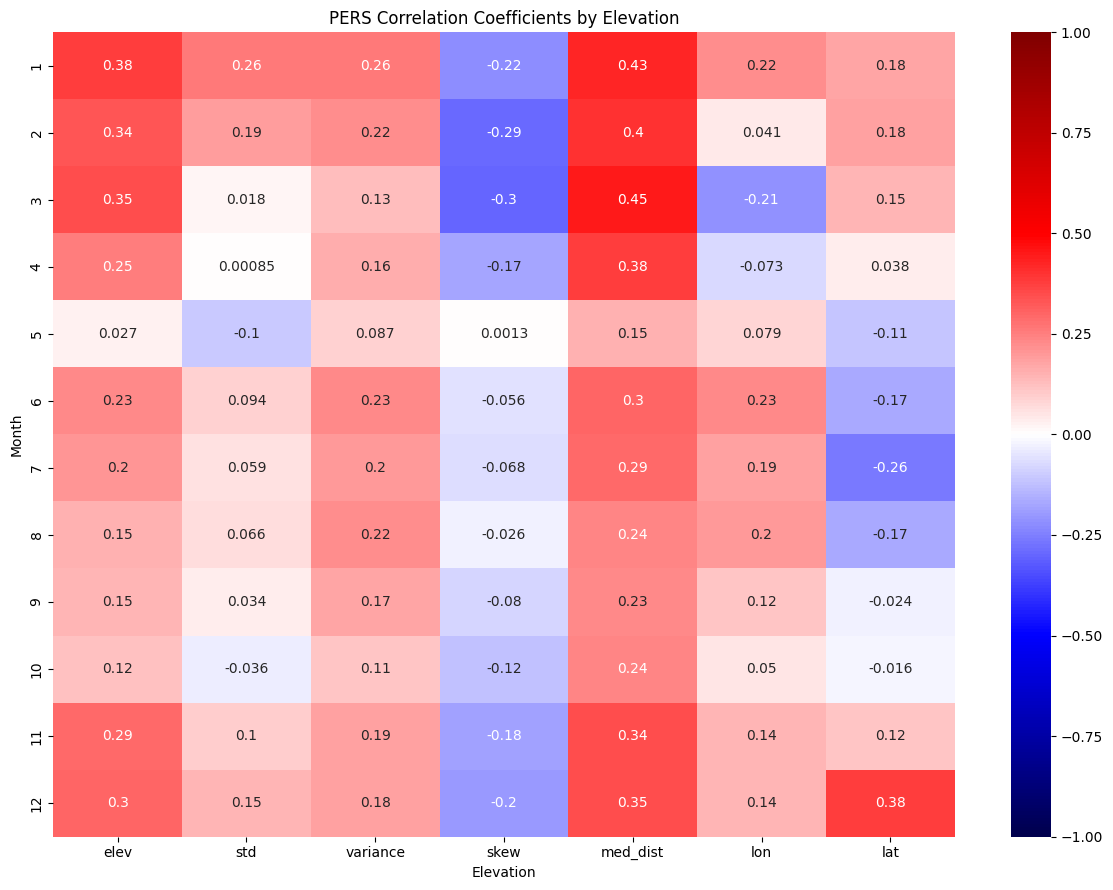

In [12]:
plot_heatmap(df_pers, "PERS")

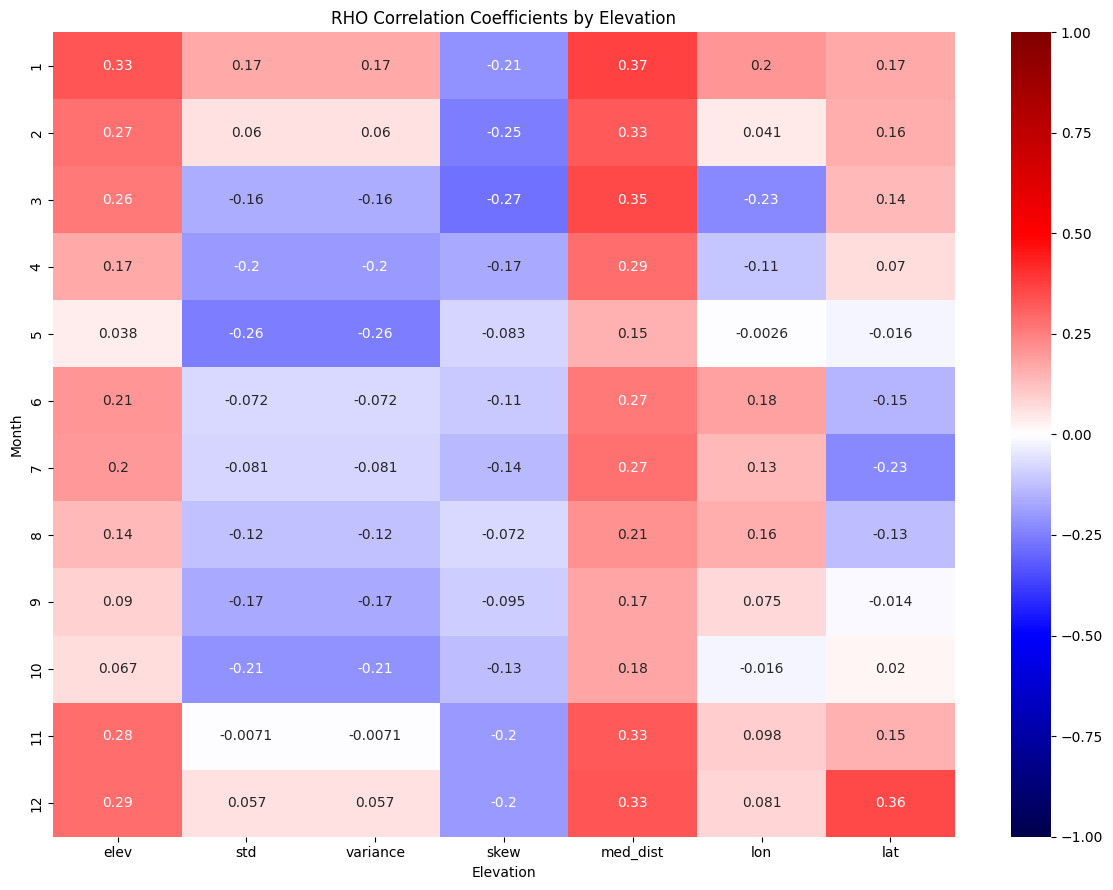

In [13]:
plot_heatmap(df_rho, "RHO")

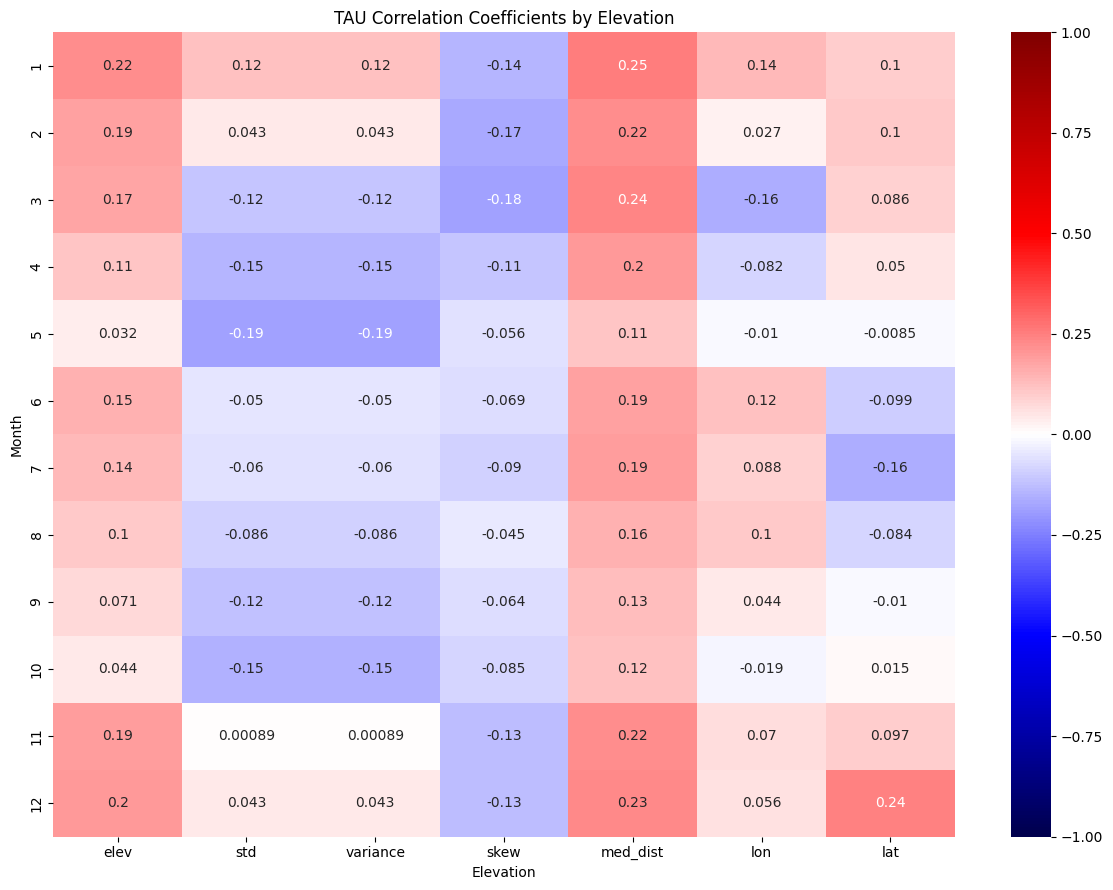

In [14]:
plot_heatmap(df_tau, "TAU")

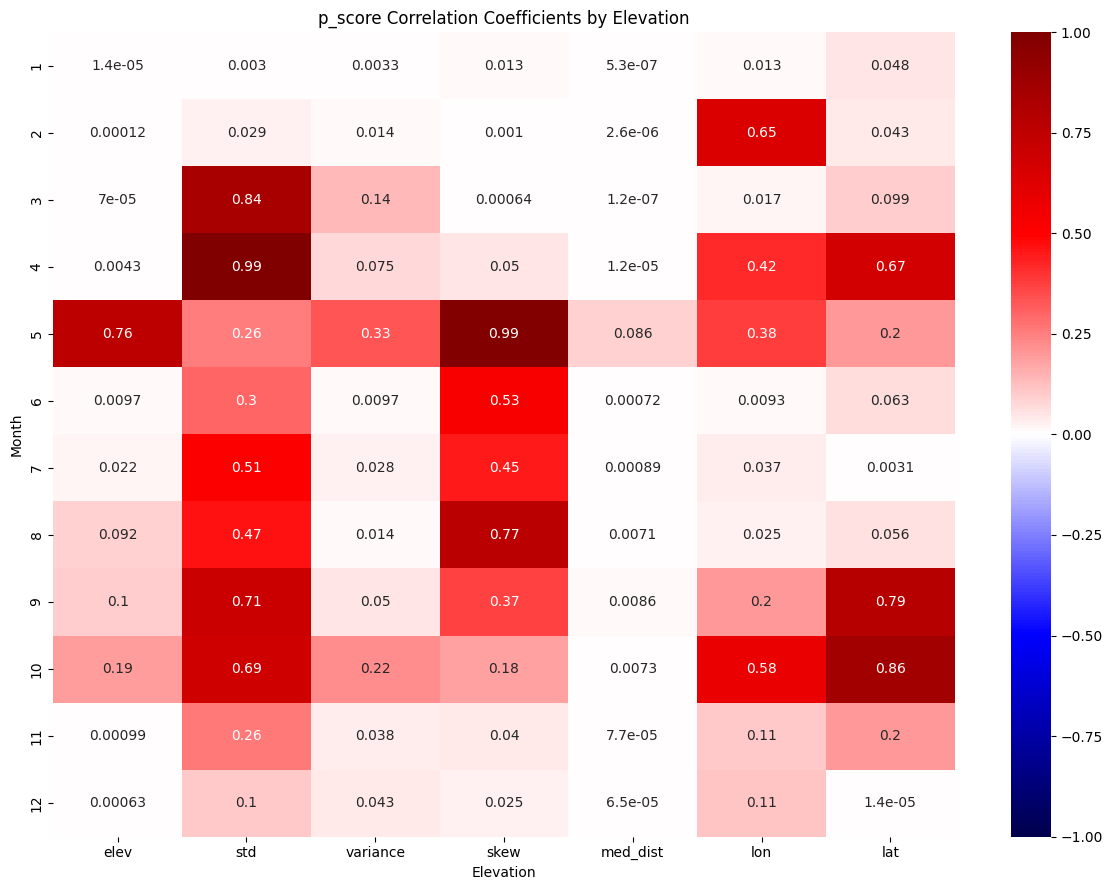

In [15]:
plot_heatmap(df_p_score, "p_score")